# Formation Voltage Decay Study

Author: Andrew Weng, Created: 3.18.2021

The "6-hour voltage decay at 100% SOC" signal is correlated to cell capacity retention after 400 cycles. We want to understand what mechanisms this signal could be related to. Peter Attia suggested looking at the shape of the C/20 charge voltage curve preceding this 6-hour voltage decay. If the shape is different, then this could indicate that differences in the voltage decay could be due to differences in voltage curve shape, e.g. due to differences in relative stoic alignment.

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'code-base':
    os.chdir('../')
sys.path.append('code-base')

import numpy as np
import pandas as pd
import glob
import pprint
from scipy.stats import pearsonr
from datetime import datetime
from scipy.stats import ttest_ind
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from sklearn.linear_model import LinearRegression
import re
from src.formation import FormationCell

In [2]:
assert os.path.basename(os.getcwd()) == 'project-formation'

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Configure plot settings

In [4]:
# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Times New Roman'],
                  'size': 26
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (10, 8),
                    'facecolor'  : 'white'
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes',  labelsize='medium', grid=True)
plt.rc('axes',  titlesize='medium')
plt.rc('legend', fontsize='medium')

DPI = 600

## Load resources

In [5]:
formation_cells = []
cellid_list = np.arange(1, 41)

for cellid in cellid_list:
    formation_cells.append(FormationCell(cellid))

## Process the Baseline Formation Data

### Assign the colormaps

In [6]:
delta_v_vec = []
for cell in formation_cells:
    
    if cell.cellid == 9:
        continue
    
    if not cell.is_baseline_formation():
        continue
        
    stats = cell.get_formation_test_summary_statistics()
    delta_v_vec.append(stats['form_6hr_rest_delta_voltage_v'])
    
color_norm  = colors.Normalize(vmin=np.min(delta_v_vec), 
                               vmax=np.max(delta_v_vec))

cmap = plt.get_cmap('bwr') 

scalar_map = cmx.ScalarMappable(norm=color_norm, cmap=cmap)

### Make the plots

[Text(0.5, 0, 'Charge dV/dQ (V/Ah)'),
 Text(0, 0.5, '$\\Delta$ Capacity (Ah)'),
 Text(0.5, 1.0, 'Baseline Formation')]

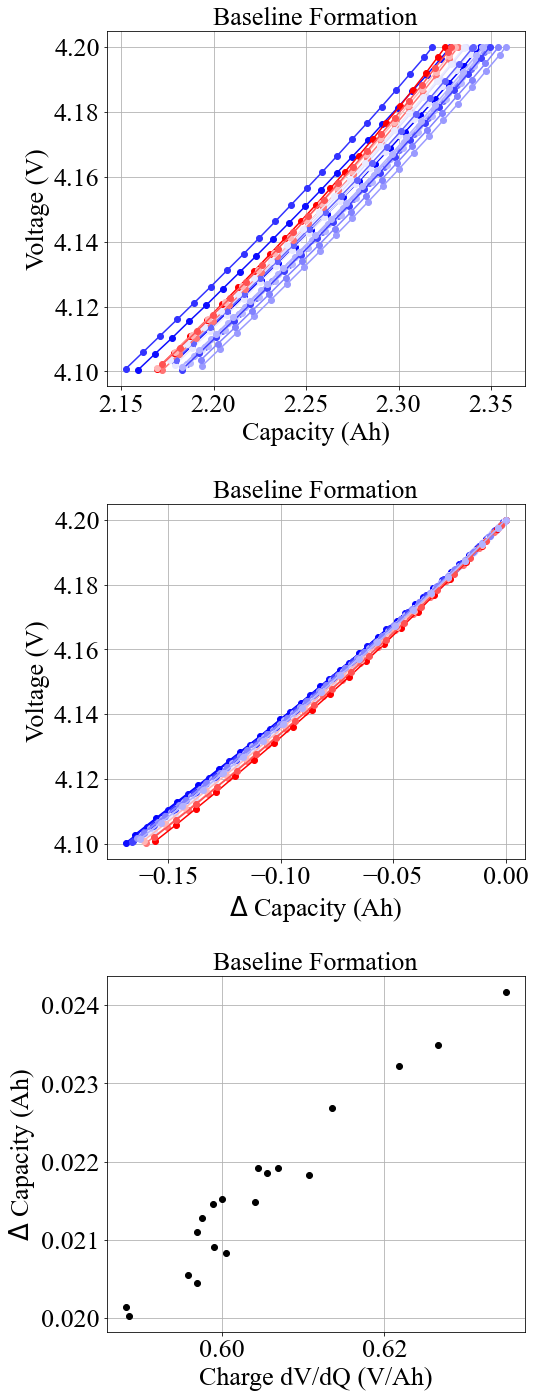

In [7]:
fig = plt.figure(figsize=(8,20))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

for cell in formation_cells:
    
    if cell.cellid == 9:
        continue
        
    if not cell.is_baseline_formation():
        continue
        
    res = dict()

    res['cellid'] = cell.cellid
    res['channel_number'] = cell.get_channel_number()
    res['is_room_temp_aging'] = 1 if cell.is_room_temp() else 0
    res['is_baseline_formation'] = 1 if cell.is_baseline_formation() else 0
    
    # Add information from the formation cycles
    res.update(cell.get_formation_test_summary_statistics())

    delta_v = res['form_6hr_rest_delta_voltage_v']
    capacity = np.array(res['form_last_charge_voltage_trace_cap_ah'])
    voltage = np.array(res['form_last_charge_voltage_trace_voltage_v'])
        
    # Calculate the dV/dQ slope during the charge step
    reg = LinearRegression().fit(capacity.reshape((-1, 1)), voltage)
    charge_dvdq = reg.coef_[0]
        
    ax1.plot(capacity, voltage, 'o-',
             color=scalar_map.to_rgba(delta_v))
    
    ax2.plot(capacity - np.max(capacity), voltage, 'o-',
             color=scalar_map.to_rgba(delta_v))
    
    ax3.plot(charge_dvdq, delta_v, 'o', color=(0,0,0))
    
ax1.set(xlabel='Capacity (Ah)', ylabel='Voltage (V)', title='Baseline Formation')
ax2.set(xlabel='$\Delta$ Capacity (Ah)', ylabel='Voltage (V)', title='Baseline Formation')
ax3.set(xlabel='Charge dV/dQ (V/Ah)', ylabel='$\Delta$ Capacity (Ah)', title='Baseline Formation')

In these plots, redder colors mean higher $\Delta V_{6hr}$, and bluer colors mean lower $\Delta V_{6hr}$.

## Process the Fast Formation Data

### Assign the colormaps

In [8]:
delta_v_vec = []
for cell in formation_cells:
    
    if cell.cellid == 9:
        continue
    
    if cell.is_baseline_formation():
        continue
        
    stats = cell.get_formation_test_summary_statistics()
    delta_v_vec.append(stats['form_6hr_rest_delta_voltage_v'])
    
color_norm  = colors.Normalize(vmin=np.min(delta_v_vec), 
                               vmax=np.max(delta_v_vec))

cmap = plt.get_cmap('bwr') 

scalar_map = cmx.ScalarMappable(norm=color_norm, cmap=cmap)

### Make the plots

[Text(0.5, 0, 'Charge dV/dQ (V/Ah)'),
 Text(0, 0.5, '$\\Delta$ Capacity (Ah)'),
 Text(0.5, 1.0, 'Fast Formation')]

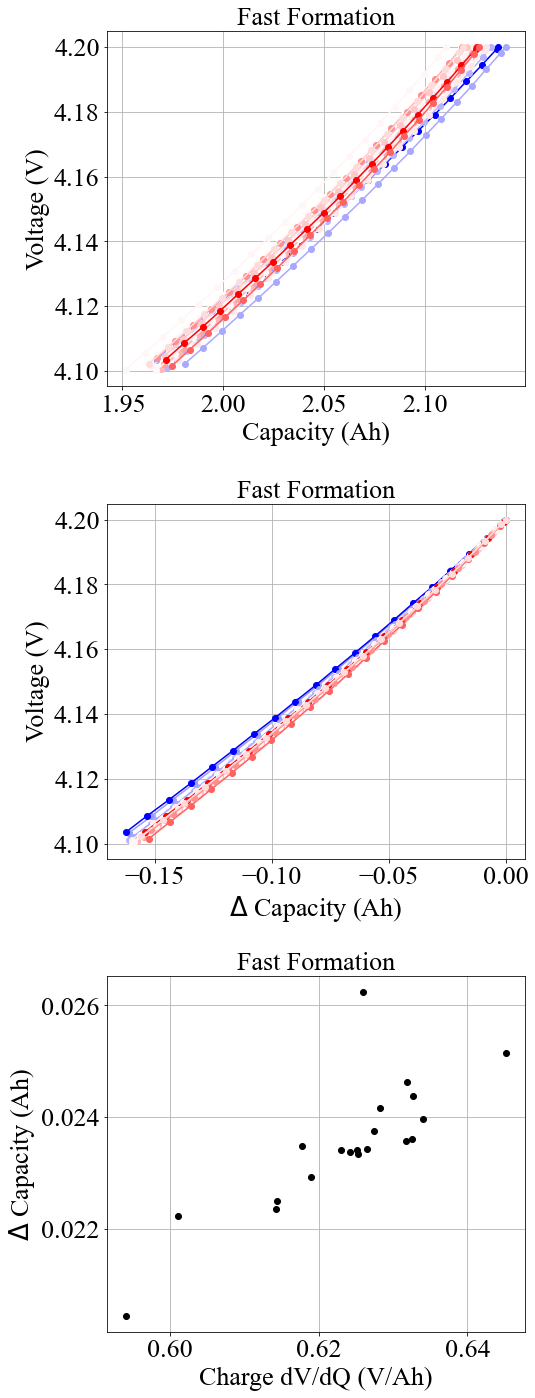

In [9]:
fig = plt.figure(figsize=(8,20))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

for cell in formation_cells:
    
    if cell.cellid == 9:
        continue
        
    if cell.is_baseline_formation():
        continue
        
    res = dict()

    res['cellid'] = cell.cellid
    res['channel_number'] = cell.get_channel_number()
    res['is_room_temp_aging'] = 1 if cell.is_room_temp() else 0
    res['is_baseline_formation'] = 1 if cell.is_baseline_formation() else 0
    
    # Add information from the formation cycles
    res.update(cell.get_formation_test_summary_statistics())

    delta_v = res['form_6hr_rest_delta_voltage_v']
    capacity = np.array(res['form_last_charge_voltage_trace_cap_ah'])
    voltage = np.array(res['form_last_charge_voltage_trace_voltage_v'])
        
    # Calculate the dV/dQ slope during the charge step
    reg = LinearRegression().fit(capacity.reshape((-1, 1)), voltage)
    charge_dvdq = reg.coef_[0]
        
    ax1.plot(capacity, voltage, 'o-',
             color=scalar_map.to_rgba(delta_v))
    
    ax2.plot(capacity - np.max(capacity), voltage, 'o-',
             color=scalar_map.to_rgba(delta_v))
    
    ax3.plot(charge_dvdq, delta_v, 'o', color=(0,0,0))
    
ax1.set(xlabel='Capacity (Ah)', ylabel='Voltage (V)', title='Fast Formation')
ax2.set(xlabel='$\Delta$ Capacity (Ah)', ylabel='Voltage (V)', title='Fast Formation')
ax3.set(xlabel='Charge dV/dQ (V/Ah)', ylabel='$\Delta$ Capacity (Ah)', title='Fast Formation')

## Both Baseline Plus Fast Formation

In [10]:
delta_v_vec = []
for cell in formation_cells:
    
    if cell.cellid == 9:
        continue
        
    stats = cell.get_formation_test_summary_statistics()
    delta_v_vec.append(stats['form_6hr_rest_delta_voltage_v'])
    
color_norm  = colors.Normalize(vmin=np.min(delta_v_vec), 
                               vmax=np.max(delta_v_vec))

cmap = plt.get_cmap('bwr') 

scalar_map = cmx.ScalarMappable(norm=color_norm, cmap=cmap)

[Text(0.5, 0, 'Charge dV/dQ (V/Ah)'),
 Text(0, 0.5, '$\\Delta V_{6hr}$ (Ah)'),
 Text(0.5, 1.0, 'square: fast, circle: baseline')]

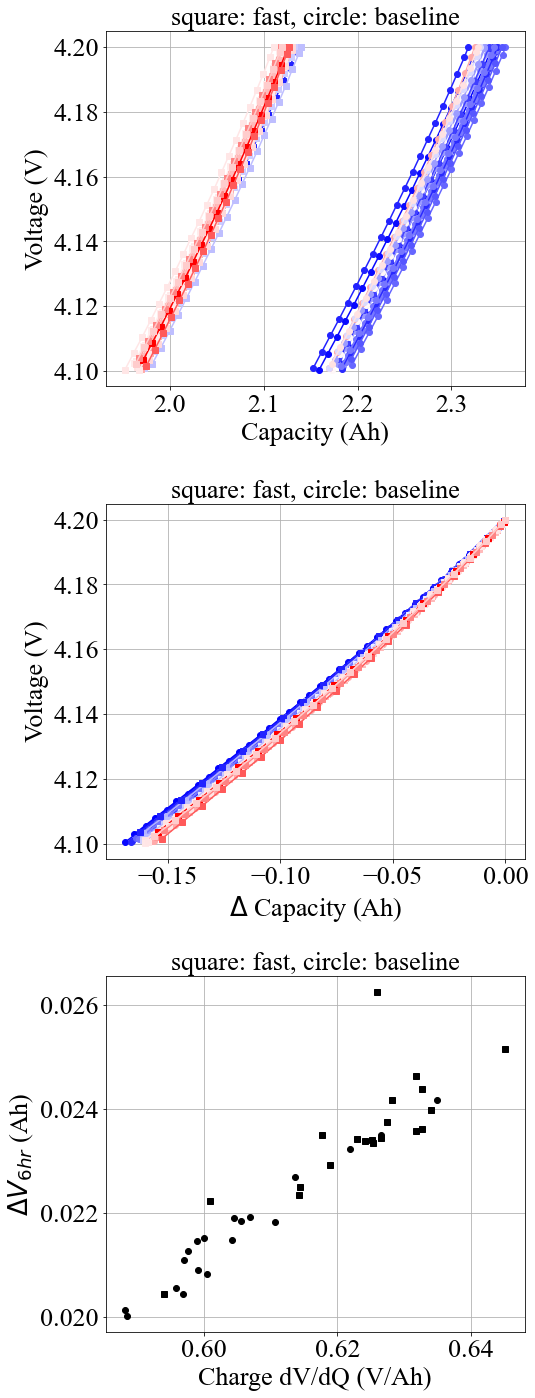

In [11]:
fig = plt.figure(figsize=(8,20))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

for cell in formation_cells:
    
    if cell.cellid == 9:
        continue
        
    if cell.is_baseline_formation():
        marker = 'o'
    else:
        marker = 's'
        
    res = dict()

    res['cellid'] = cell.cellid
    res['channel_number'] = cell.get_channel_number()
    res['is_room_temp_aging'] = 1 if cell.is_room_temp() else 0
    res['is_baseline_formation'] = 1 if cell.is_baseline_formation() else 0
    
    # Add information from the formation cycles
    res.update(cell.get_formation_test_summary_statistics())

    delta_v = res['form_6hr_rest_delta_voltage_v']
    capacity = np.array(res['form_last_charge_voltage_trace_cap_ah'])
    voltage = np.array(res['form_last_charge_voltage_trace_voltage_v'])
        
    # Calculate the dV/dQ slope during the charge step
    reg = LinearRegression().fit(capacity.reshape((-1, 1)), voltage)
    charge_dvdq = reg.coef_[0]
        
    ax1.plot(capacity, voltage, f'{marker}-',
             color=scalar_map.to_rgba(delta_v))
    
    ax2.plot(capacity - np.max(capacity), voltage, f'{marker}-',
             color=scalar_map.to_rgba(delta_v))
    
    ax3.plot(charge_dvdq, delta_v, marker, color=(0,0,0))
    
ax1.set(xlabel='Capacity (Ah)', ylabel='Voltage (V)', title='square: fast, circle: baseline')
ax2.set(xlabel='$\Delta$ Capacity (Ah)', ylabel='Voltage (V)', title='square: fast, circle: baseline')
ax3.set(xlabel='Charge dV/dQ (V/Ah)', ylabel='$\Delta V_{6hr}$ (Ah)', title='square: fast, circle: baseline')

## Summary of findings

- Cells having higher $\Delta V_{6hr}$ also have a higher voltage slope during the preceding C/20 charge to 4.20V step.
- What could this mean?
  - One possibility (Peter's suggestion): the delta V can be explained by a shift in the equilibrium potential curve. This shift in the equilibrium potential curve could be due to a shift in the relative alignment between the positive and negative electrode stoichimetries at 100% SOC (i.e. $y_{100}$ and $x_{100}$). This could be caused by a loss of $C_n$ or a change in the lithium inventory. In the plots above, this shift in equilibrium potential is enough to explain up to 10mV of difference observed in the $\Delta V_{hr}$ signal.
  - One caveat: this is a C/20 curve which is not fully at equilibrium. There could still be some kinetic limitation at this part of the curve.
  
Misc notes:
- Note that $\Delta V_{hr}$ is separated from the C/20 charge by a C/100 cut.


### Is the correlation due to stoic shift, kinetic differences, or both?

To try to rule out kinetic differences as the cause of the correlation, we will do some simple estimates of overpotential. 

The approach is to estimate the _variation_ in overpotential due to the _variation_ in the measured 10-second resistances. See if the magnitude of this is sufficient to explain the _variation_ in voltages seen here.

To start, observe that in the C/20 charge voltage leading up to the 4.2V hold has a _variation_ of 26mV - 20mV = 6mV. So we will check if the overpotential variation due to the resistance variation can account for up to 6mV of difference at the C/20 charge rate.

We are interested in the room temperature, 100% SOC DCR, since this is the condition that matches the formation. Here, we see that the 10-s discharge resistance (DCR) varies between 22 $m\Omega$ to 25.5 $m\Omega$ = 3.5 $m\Omega$. 

![](imgs/initial-cell-dcr-comparison.png)

At a C/20 charge rate = 0.25 A, the corresponding voltage drop _variation_ is $V = IR = (0.25 A) \cdot (0.0035 \Omega) = 0.875 mV$.

From this calculation, we may conclude **that kinetic differences of time scale <10s contributes up to less than 1mV of the total 6mV variation seen**. So at least 5mV of the voltage variation is coming from 'something else'. What is the 'something else'? It could still be due to two things:

1. Electrode stoic shifts (pure thermodynamic shifts)
2. Kinetic differences of time scale > 10s, e.g. diffusion

Since we don't have resistance measurements beyond 10s, we can only speculate which of these two factors dominate. It could be reasonable to assume that (1) is at least contributing, since we _know_ (1) is happening due to the lowering of $C_n$.